In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from datasets import load_dataset




In [7]:

# Load the dataset
df = pd.read_csv("../dataset/structural_split/train.csv", low_memory=False)
df.drop(columns=["Unnamed: 0"], inplace=True)
# Drop missing sequences
df = df.dropna(subset=["protein1", "protein2"])



In [8]:
df.head()


,entry,protein2,uniprot_description,rank,protein1,protein_name,function,GPT_description,all_description
0,Q8N884-D95A,MQPWHGKAMQRASEAGATAPKASARNARGAPMDPTESPAAPEAALP...,No effect on type I IFN and RSAD2 induction. N...,NaN,MQPWHGKAMQRASEAGATAPKASARNARGAPMDPTESPAAPEAALP...,Cyclic GMP-AMP synthase,Nucleotidyltransferase that catalyzes the form...,NaN,No effect on type I IFN and RSAD2 induction. N...
1,P06276-L153F,MHSKVTIICIRFLFWFLLLCMLIGKSHTEDDIIIATKNGKVRGMNL...,In BCHED; seems to cause reduced expression of...,NaN,MHSKVTIICIRFLFWFLLLCMLIGKSHTEDDIIIATKNGKVRGMNL...,Cholinesterase,Esterase with broad substrate specificity. Con...,The mutation in the BCHE gene leads to reduced...,In BCHED; seems to cause reduced expression of...
2,P63096-E245L,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...,Enhances interaction (inactive GDP-bound) with...,NaN,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGK...,Guanine nucleotide-binding protein G,Guanine nucleotide-binding proteins (G protein...,NaN,Enhances interaction (inactive GDP-bound) with...
3,O35244-S32A,MPGGLLLGDEAPNFEANTTIGHIRFHDFLGDAWGILFSHPRDFTPV...,Abolishes lipid binding.,NaN,MPGGLLLGDEAPNFEANTTIGHIRFHDFLGDSWGILFSHPRDFTPV...,Peroxiredoxin-6,Thiol-specific peroxidase that catalyzes the r...,"Increased Prdx6 alpha-helical content, key rol...",Abolishes lipid binding. Increased Prdx6 alpha...
4,P80365-R337C,MERWPWPSGGAWLLVAARALLQLLRSDLRLGRPLLAALALLAALDW...,In AME; decreased half-life from 21 to 4 hours...,NaN,MERWPWPSGGAWLLVAARALLQLLRSDLRLGRPLLAALALLAALDW...,11-beta-hydroxysteroid dehydrogenase type 2,Catalyzes the conversion of biologically activ...,This mutation has been discovered in a consang...,In AME; decreased half-life from 21 to 4 hours...


In [9]:
df.shape

(165236, 9)

In [10]:

# Load ESM model
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, add_pooling_layer=False).eval()



In [11]:

def embed_sequence(seq):
    """Embed a protein sequence using mean-pooled ESM embeddings."""
    tokens = tokenizer(seq, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens).last_hidden_state
    return outputs.mean(dim=1).squeeze().numpy()

# Embed all protein1 and protein2 sequences
protein1_embeddings = []
protein2_embeddings = []
# Use a small subset for speed (remove this line to run on full dataset)
df = df.sample(n=15, random_state=42)
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        emb1 = embed_sequence(row["protein1"])
        emb2 = embed_sequence(row["protein2"])
        protein1_embeddings.append(emb1)
        protein2_embeddings.append(emb2)
    except Exception as e:
        print("Embedding error:", e)


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


In [12]:


# Combine protein1 and protein2 embeddings
all_embeddings = np.vstack([protein1_embeddings, protein2_embeddings])

# Reduce dimensionality
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_coords = tsne.fit_transform(all_embeddings)

# Separate again
n = len(protein1_embeddings)
pt1_coords = tsne_coords[:n]
pt2_coords = tsne_coords[n:]



/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/bio/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


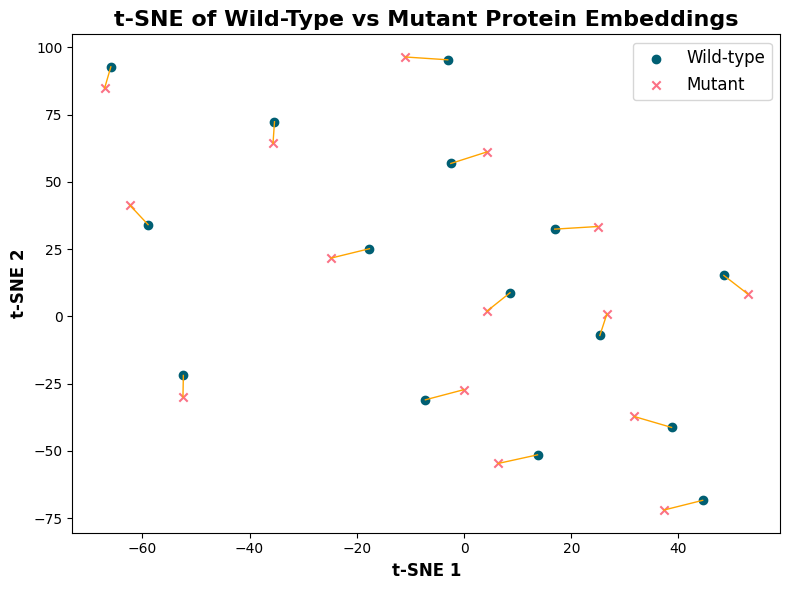

In [13]:

# Plot
fig = plt.figure(figsize=(8, 6))
plt.title("t-SNE of Wild-Type vs Mutant Protein Embeddings", fontsize=16, weight='bold')

# Orange line connections
for i in range(n):
    plt.plot([pt1_coords[i, 0], pt2_coords[i, 0]], [pt1_coords[i, 1], pt2_coords[i, 1]], c='orange', lw=1)

# Scatter points
plt.scatter(pt1_coords[:, 0], pt1_coords[:, 1], c="#005f73", marker="o", label="Wild-type")  # wild-type
plt.scatter(pt2_coords[:, 0], pt2_coords[:, 1], c="#fb7185", marker="x", label="Mutant")  # mutant
plt.legend(loc="best", prop={"weight": "bold"})

plt.xlabel("t-SNE 1", fontsize=12, fontweight='bold')
plt.ylabel("t-SNE 2", fontsize=12, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
fig.savefig("../output/figure/tsne_wt_mutant.tiff", dpi=300)
plt.close()

In [21]:
# Prepare metadata for visualization and saving
meta_data = pd.DataFrame({
    "tsne_1": np.concatenate([pt1_coords[:, 0], pt2_coords[:, 0]]),
    "tsne_2": np.concatenate([pt1_coords[:, 1], pt2_coords[:, 1]]),
    "type": ["protein1"] * n + ["protein2"] * n,
    "uniprot_description": pd.concat([df["uniprot_description"], df["uniprot_description"]], ignore_index=True),
    "function": pd.concat([df["function"], df["function"]], ignore_index=True),
    "protein_name": pd.concat([df["protein_name"], df["protein_name"]], ignore_index=True),
})

# Save to CSV
meta_data.to_csv("../output/data/tsne_embeddings_with_metadata.csv", index=False)


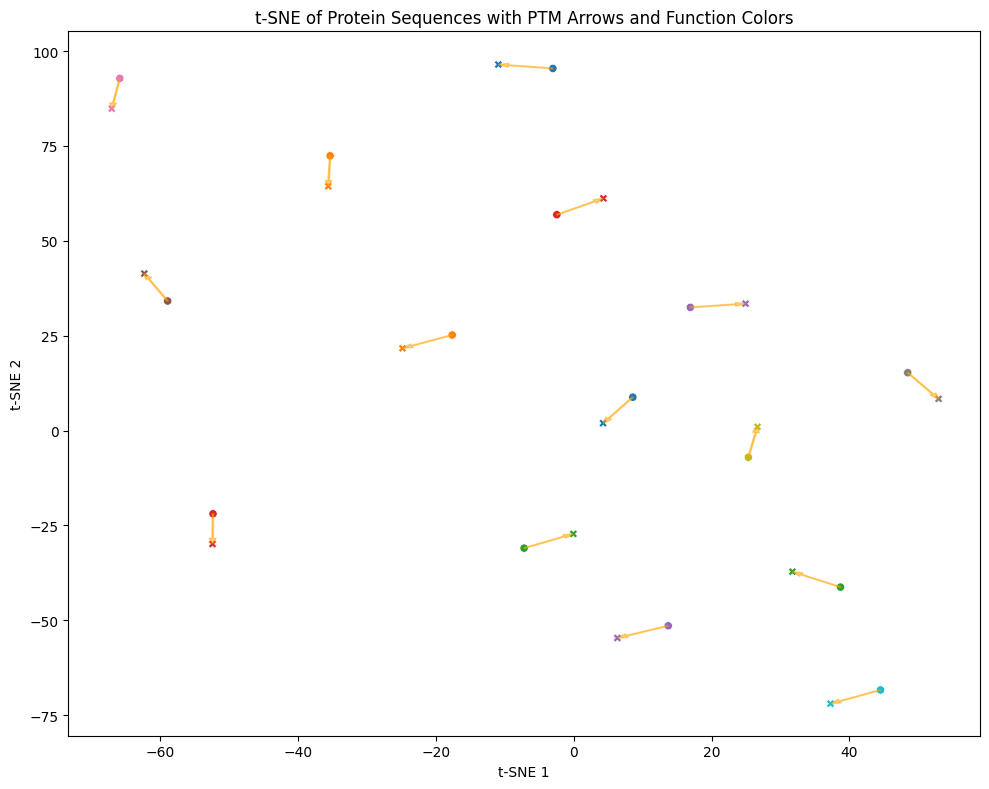

In [22]:
# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=meta_data,
    x="tsne_1", y="tsne_2",
    hue="protein_name",
    style="type",
    palette="tab10"
)

# Draw arrows from protein1 to protein2
for i in range(n):
    plt.arrow(
        pt1_coords[i, 0], pt1_coords[i, 1],
        pt2_coords[i, 0] - pt1_coords[i, 0],
        pt2_coords[i, 1] - pt1_coords[i, 1],
        color="orange", alpha=0.5,
        width=0.2, head_width=1.0, length_includes_head=True
    )

plt.title("t-SNE of Protein Sequences with PTM Arrows and Function Colors")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
# plt.legend(
#     bbox_to_anchor=(1.02, 1),
#     loc="upper left",
#     borderaxespad=0,
#     fontsize="x-small",     # smaller font
#     markerscale=0.7,        # smaller legend markers
#     ncol=1,                 # vertical layout
# )
plt.legend().remove()

plt.tight_layout(rect=[0, 0, 0.72, 1])
#plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()